#### DEEP LEARNING MODEL DEPLOYMENT (Bi-LSTM)

<span style="color:coral">Data Preparation</span>

In [1]:
import numpy as np
import pandas as pd
import re
from colorama import Fore, Back, Style

In [2]:
dataset = pd.read_excel('dataset/maya_dataset.xlsx', engine = 'openpyxl')
dataset = dataset.iloc[:, 0:2]
df_1 = dataset.copy()

In [3]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F97A"
        u"\U00002639"
        u"\U0001F642"
        u"\U00002764"
        u"\U0001F600-\U000E007F"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)

def depunctuate(text):
    regrex_pattern = re.compile(pattern = "["u"\/"u"\\"u"\^"u"\!"u"\@"u"\+"u"\*"u"\="u"\%"u"\&"u"\:"u"\;"u"\_"u"\."u"\,"u"\("u"\)"u"\?"u"\।"u"\|"u"'"u"\-"u"\""u"]+")
    return regrex_pattern.sub(r' ',text)

def denumerize(text):
    regrex_pattern = re.compile(pattern = "[0-9০১২৩৪৫৬৭৮৯]+")
    return regrex_pattern.sub(r' ',text)

def remove_empty_string_literals(string_list):
    while("" in string_list) :
        string_list.remove("")
    return string_list

In [4]:
for i in range(df_1.shape[0]):
    df_1.iloc[i,0] = deEmojify(df_1.iloc[i,0])
df_2 = df_1.copy()
for i in range(df_2.shape[0]):
    df_2.iloc[i,0] = depunctuate(df_2.iloc[i,0])
df_3 = df_2.copy()
for i in range(df_3.shape[0]):
    df_3.iloc[i,0] = denumerize(df_3.iloc[i,0])
df_4 = df_3.copy()
df_4['length'] = [len(remove_empty_string_literals(post.split(' '))) for post in df_4.iloc[:, 0]]

LOWER_BOUND = 5
UPPER_BOUND = 300
df_5 = df_4[(df_4['length'] >= LOWER_BOUND) == True]
df_5 = df_5[(df_5['length'] <= UPPER_BOUND) == True]
print(df_5.shape)



(4871, 3)


<span style="color:crimson">Spell Correction using FastText</span>

<font>Source:
    https://medium.com/analytics-vidhya/bengali-word-spelling-correction-using-pre-trained-word2vec-1f9938f48b09
</font>

- letters = The Bengali script has a total of 9 vowels. Each of which is called a ‘স্বরবর্ণ’. Also, have 35 consonants that are known as ‘ব্যঞ্জনবর্ণ ‘.

- splits = It is working as a list which has both forward and reverses orders of the word sequence.

- deletes = Also, a list which checks the left and right of a word in splits list and deletes the incorrect syntax.

- transposes = It is used to change word places with each other words using the splits list.

- replaces = Is a list it put words back in a previous place or position.

- inserts = It helps to place and fit the correct words into the replacing with the incorrect word, especially with care.

In [5]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('models/cc.bn.300.vec')

In [6]:
words = model.index_to_key
word_rank = {}
for index, word in enumerate(words):
    word_rank[word] = index
len(words)

1468578

In [7]:
# This methods returns the value for the given key, if present in the dictionary using the get() method
def P(word): 
    return - word_rank.get(word, 0)

#  It returns the maximum candidates words with a key which is defined by P
def correction(word): 
    return max(candidates(word), key=P)

# The absolute candidate of the wrong word could found from known() methods is the actual work of this function.
def candidates(word): 
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

# This method is used to find out the set of a word which is present in the dictionary
def known(words): 
    return set(w for w in words if w in word_rank)

# Many parameters such as deletes, transposes, replaces, inserts are used in this method.
# Those parameters return the correct word of an incorrect word in a sentence.
# A set() function is used to find out the unordered collection of words
def edits1(word):
    letters    = 'ঁংঃঅআইঈউঊঋএঐওঔকখগঘঙচছজঝঞটঠডঢণতথদধনপফবভমযরলশষসহ়ঽািীুূৃৄেৈোৌ্ৎৗড়ঢ়য়'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
    
#  This method is returend the word which is edited by in edits1() functions
def edits2(word): 
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [8]:
def spell_correction(sentence):
    corrected_sentence = []
    for word in sentence:
        corrected_sentence.append(correction(word))
    return re.sub(' +' ,' ', ' '.join(corrected_sentence))
from bnlp import BasicTokenizer
tokenizer = BasicTokenizer()
x = df_5.iloc[:, 0:1].values
x = x.tolist()
for i in range(len(x)):
    x[i] = tokenizer.tokenize(x[i][0])
for i in range(df_5.shape[0]):
    df_5.iloc[i, 0] = spell_correction(x[i])

In [9]:
from bnlp.corpus.util import remove_stopwords
file = open('stopwords/stopwords-bn.txt', encoding = 'utf-8')
stopwords = []
for line in file:
    stopwords.append(line.strip())
file.close()
stopwords = list(filter(None, stopwords))
df_6 = df_5.iloc[:, 0:2].copy()
for i in range(df_6.shape[0]):
    df_6.iloc[i, 0] = ' '.join(remove_stopwords(df_6.iloc[i, 0], stopwords))
x, y = df_6.iloc[:, 0:1].values, df_6.iloc[:, 1:2].values
x = x.tolist()
corpus = df_6.iloc[:, 0].values
y = df_6.iloc[:, 1].values

from bnlp import BasicTokenizer
tokenizer = BasicTokenizer()
# X -> tokenized list of sentences(lists); x -> list of sentences
X, y = df_6.iloc[:, 0:1].values, df_6.iloc[:, 1:2].values
X = X.tolist()
for i in range(len(X)):
    X[i] = tokenizer.tokenize(X[i][0])

In [10]:
# one hot encoding y
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown = 'ignore')
y = np.array((enc.fit_transform(y)).toarray())

# split and tokenize
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
from tensorflow.keras import preprocessing
tokenizer = preprocessing.text.Tokenizer(lower = False, oov_token = '<UNK>')
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(x_train)
x_train = preprocessing.sequence.pad_sequences(sequences = x_train, padding = 'post', truncating = 'post',
                                              maxlen = UPPER_BOUND)
x_test = tokenizer.texts_to_sequences(x_test)
x_test = preprocessing.sequence.pad_sequences(sequences = x_test, padding = 'post', truncating = 'post',
                                             maxlen = UPPER_BOUND)

In [11]:
print(np.array(x_train).shape)
print(np.array(x_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)

(3653, 300)
(1218, 300)
(3653, 4)
(1218, 4)


In [12]:
print("final form")
df_6.head(5)

final form


,posts,labels
0,কিভাবে হতাশা রক্ষা পাওয়া,2
1,মাথা সঠিক না মানসিক বিষন্নতা দুঃচিন্তা একাকিত্...,3
2,কিছুদিন যাবৎ ডিপ্রেসন আছি ভালো লাগছে সবসময় অস...,2
3,ডিপ্রেশন বেরিয়ে আসতে পারতেছি না,2
4,বয়স জীবনে সবকিছু মত পেতে চাই বাট পাওয়া না অল্প...,2


In [13]:
print("initial form")
df_1.head(5)

initial form


,posts,labels
0,কিভাবে হতাশা থেকে রক্ষা পাওয়া যাবে,2
1,"মাথা সঠিক কাজ করে না, মানসিক বিষন্বতা, দুঃসচিন...",3
2,আমি বেশ কিছুদিন যাবৎ অনেক ডিপ্রেসন এ আছি। আমার...,2
3,কোনো ভাবেই ডিপ্রেশন থেকে বেরিয়ে আসতে পারতেছি না,2
4,আমার বয়স ৩৪ বছর।জীবনে সবকিছু আমার মত করে পেতে ...,2


<span style="color:pink">Creating FastText Word Embeddings</span>

In [14]:
vocab_dictionary = tokenizer.word_index

In [15]:
embeddings = np.zeros((len(vocab_dictionary) + 1, 300))
for word, idx in vocab_dictionary.items():
    try:
        embeddings[idx] = model[word]
    except:
        pass

<span style="color:gold">Deploying Bidirectional-RNN</span>

In [79]:
import keras
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend

In [80]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(np.reshape(enc.inverse_transform(y_train), y_train.shape[0])),
                                                 np.reshape(enc.inverse_transform(y_train), y_train.shape[0]))
class_weights = {0 : class_weights[0],
               1 : class_weights[1],
               2 : class_weights[2],
               3 : class_weights[3]}

C:\ProgramData\Anaconda3\envs\virtual\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[1 2 3 4], y=[2 1 2 ... 1 3 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [81]:
class_weights

{0: 0.5846670934699104,
 1: 0.8074712643678161,
 2: 1.7102059925093633,
 3: 2.1437793427230045}

In [82]:
# Callbacks

# accuracy threshold
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs = {}): 
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
acc_threshold = myCallback()

# save best model
from keras.callbacks import ModelCheckpoint
filepath = 'saved-models/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath = filepath, 
                             monitor = 'val_loss',
                             verbose = 1, 
                             save_best_only = True,
                             mode = 'min')

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
reduce_on_plateau = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=2,
            verbose=0,
            mode='min',
            min_delta=0.01,
            cooldown=0,
            min_lr=0)
tensor_board = TensorBoard(log_dir = 'tb_logs',
                           update_freq = 1)

In [83]:
inputs = layers.Input(shape = (x_train.shape[1],))
neurons = x_train.shape[1]
modl_in = layers.Embedding(input_dim = embeddings.shape[0],
                    output_dim = embeddings.shape[1],
                    weights = [embeddings],
                    input_length = x_train.shape[1], trainable = False)(inputs)

In [84]:
modl = layers.Conv1D(filters = 1024,
                     kernel_size= 3,
                     strides = 1,
                     activation = 'relu')(modl_in)
modl = layers.MaxPooling1D(pool_size = 3)(modl)
modl = layers.Conv1D(filters = 512,
                     kernel_size= 3,
                     strides = 1,
                     activation = 'relu')(modl)
modl = layers.MaxPooling1D(pool_size = 5)(modl)
modl = layers.Conv1D(filters = 256,
                     kernel_size= 3,
                     strides = 1,
                     activation = 'relu')(modl)
modl = layers.MaxPooling1D(pool_size = 17)(modl)
modl = layers.SpatialDropout1D(0.5)(modl)
modl = SeqSelfAttention(attention_activation='sigmoid', name = 'Self-Attention')(modl)
modl = layers.Reshape(target_shape = (modl.shape[2],))(modl)
from tensorflow.keras import regularizers
modl = layers.Dense(units=64,
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                    bias_regularizer=regularizers.l2(1e-4),
                    activity_regularizer=regularizers.l2(1e-5))(modl)
modl_out = layers.Dense(units = 4, activation = 'softmax')(modl)
# compile
modelz = models.Model(inputs, modl_out)
modelz._name = 'Bidirectional-LSTM'
modelz.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
             weighted_metrics=['accuracy'])
modelz.summary()

Model: "Bidirectional-LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 300)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 300, 300)          2989800   
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 298, 1024)         922624    
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 99, 1024)          0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 97, 512)           1573376   
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 19, 512)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 17, 256)    

In [85]:
training = modelz.fit(x = x_train, y = y_train, batch_size = 16, 
                     epochs = 5, shuffle = True, verbose = 1, 
                     validation_split = 0.3,
                     class_weight = class_weights,
                     callbacks = [acc_threshold, reduce_on_plateau])
predicted_prob = modelz.predict_on_batch(x_test)

Epoch 1/5
160/160 [==============================] - 48s 294ms/step - loss: 1.2043 - accuracy: 0.4870 - val_loss: 0.9573 - val_accuracy: 0.6551
Epoch 2/5
160/160 [==============================] - 48s 302ms/step - loss: 0.7528 - accuracy: 0.7307 - val_loss: 0.6600 - val_accuracy: 0.7819
Epoch 3/5
160/160 [==============================] - 49s 304ms/step - loss: 0.4818 - accuracy: 0.8312 - val_loss: 0.7224 - val_accuracy: 0.7464
Epoch 4/5
160/160 [==============================] - 50s 311ms/step - loss: 0.3663 - accuracy: 0.8843 - val_loss: 0.7527 - val_accuracy: 0.7701
Epoch 5/5
160/160 [==============================] - 50s 312ms/step - loss: 0.2158 - accuracy: 0.9474 - val_loss: 0.6480 - val_accuracy: 0.8066


In [86]:
y_pred = np.argmax(predicted_prob, axis = 1)
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(enc.inverse_transform(y_test), y_pred+1)
cm = confusion_matrix(enc.inverse_transform(y_test), y_pred+1)
print('Classification Report', cr, sep = '\n')
print(Fore.GREEN+'Confusion Matrix', cm, '', sep = '\n')

Classification Report
              precision    recall  f1-score   support

           1       0.84      0.81      0.82       529
           2       0.75      0.78      0.77       401
           3       0.54      0.58      0.56       169
           4       0.88      0.83      0.85       119

    accuracy                           0.77      1218
   macro avg       0.75      0.75      0.75      1218
weighted avg       0.77      0.77      0.77      1218

Confusion Matrix
[[428  56  41   4]
 [ 46 312  38   5]
 [ 26  40  98   5]
 [  9   6   5  99]]



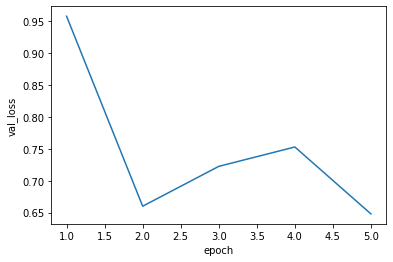

In [87]:
loss = training.history['val_loss']
ep = np.arange(len(loss))+1
import matplotlib.pyplot as plt
plt.figure().patch.set_facecolor('white')
plt.plot(ep, loss)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.show()

In [88]:
predicted_prob = modelz.predict_on_batch(x_test)
y_pred = np.argmax(predicted_prob, axis = 1)
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(enc.inverse_transform(y_test), y_pred+1)
cm = confusion_matrix(enc.inverse_transform(y_test), y_pred+1)
print('Classification Report', cr, sep = '\n')
print(Fore.GREEN+'Confusion Matrix', cm, '', sep = '\n')

Classification Report
              precision    recall  f1-score   support

           1       0.84      0.81      0.82       529
           2       0.75      0.78      0.77       401
           3       0.54      0.58      0.56       169
           4       0.88      0.83      0.85       119

    accuracy                           0.77      1218
   macro avg       0.75      0.75      0.75      1218
weighted avg       0.77      0.77      0.77      1218

Confusion Matrix
[[428  56  41   4]
 [ 46 312  38   5]
 [ 26  40  98   5]
 [  9   6   5  99]]



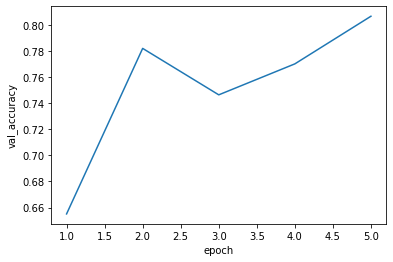

In [89]:
loss = training.history['val_accuracy']
ep = np.arange(len(loss))+1
import matplotlib.pyplot as plt
plt.figure().patch.set_facecolor('white')
plt.plot(ep, loss)
plt.xlabel('epoch')
plt.ylabel('val_accuracy')
plt.show()